### gpt사용을 위한 openAi API key 셋팅

In [1]:
import os
from dotenv import load_dotenv

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv()

# 환경 변수에서 OpenAI API 키를 가져옵니다.
openai_api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_api_key

# API 키가 존재하지 않는 경우 에러를 발생시킵니다.
if not openai_api_key:
    # API 키가 없다는 에러 메시지를 출력하고 프로그램을 종료합니다.
    raise ValueError("OpenAI API 키가 없습니다. 한 번 더 확인 부탁드립니다.")

### 검색 엔진
처음으로, 우리는 3개의 블로그 포스트를 색인화합니다.

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

그런 다음 검색 도구를 만듭니다.

In [3]:

from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

### Agent state

우리는 그래프를 정의할 것입니다.

각 노드로 전달되는 상태 객체입니다.

우리의 상태는 메시지의 리스트가 될 것입니다.

그래프의 각 노드는 그것에 추가할 것입니다.

In [5]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # add_messages 함수는 업데이트가 어떻게 처리되어야 하는지 정의합니다
    # 기본값은 대체입니다. add_messages는 "추가"라고 말합니다.
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Nodes and Edges
#### 우리는 에이전트 RAG 그래프를 다음과 같이 배치할 수 있습니다:

상태는 메시지의 집합입니다.
각 노드는 상태를 업데이트(추가)할 것입니다.
조건부 엣지는 다음에 방문할 노드를 결정합니다.

In [11]:
![langGraphAgent](./langGraphAgent.png)

zsh:1: number expected


## Edges

In [22]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

### Nodes

In [23]:
def agent(state):
    """
    현재 상태를 기반으로 에이전트 모델을 호출하여 응답을 생성합니다. 주어진 질문에 따라 검색 도구를 사용하여 검색을 수행하거나 단순히 종료하기로 결정합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 메시지에 에이전트 응답이 추가된 업데이트된 상태
    """
    print("---에이전트 호출---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # 리스트를 반환합니다, 왜냐하면 이것은 기존 리스트에 추가될 것이기 때문입니다
    return {"messages": [response]}


In [24]:
def rewrite(state):
    """
    질문을 변형하여 더 나은 질문을 생성합니다.

    Args:
        state (messages): 현재 상태

    Returns:
        dict: 재구성된 질문으로 업데이트된 상태
    """

    print("---질문 변형---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # 평가자
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

In [25]:
def generate(state):
    """
    답변 생성

    Args:
        state (messages): 현재 상태

    Returns:
         dict: 재구성된 질문으로 업데이트된 상태
    """
    print("---생성---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # 프롬프트
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # 후처리
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # 체인
    rag_chain = prompt | llm | StrOutputParser()

    # 실행
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [26]:
print("*" * 20 + "프롬프트[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # 프롬프트의 모양을 보여줍니다.

********************프롬프트[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


### Graph
시작은 에이전트로, 모델 호출을 합니다.

에이전트는 함수를 호출할지 여부를 결정합니다.

결정하면 도구(검색 도구)를 호출하는 행동을 취합니다.

그런 다음 도구의 출력을 메시지(상태)에 추가하여 에이전트를 다시 호출합니다.

In [27]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# 새로운 그래프를 정의합니다.
workflow = StateGraph(AgentState)

# 순환할 노드들을 정의합니다.
workflow.add_node("agent", agent)  # 에이전트 노드
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # 검색 도구 노드
workflow.add_node("rewrite", rewrite)  # 질문 재작성 노드
workflow.add_node(
    "generate", generate
)  # 문서가 관련성이 있다고 판단된 후 응답 생성 노드
# 에이전트 노드를 호출하여 검색을 결정합니다.
workflow.add_edge(START, "agent")

# 검색 여부를 결정합니다.
workflow.add_conditional_edges(
    "agent",
    # 에이전트 결정 평가
    tools_condition,
    {
        # 조건 출력을 그래프 내 노드로 변환
        "tools": "retrieve",
        END: END,
    },
)

# `action` 노드 호출 후 이어지는 경로
workflow.add_conditional_edges(
    "retrieve",
    # 에이전트 결정 평가
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# 컴파일
graph = workflow.compile()

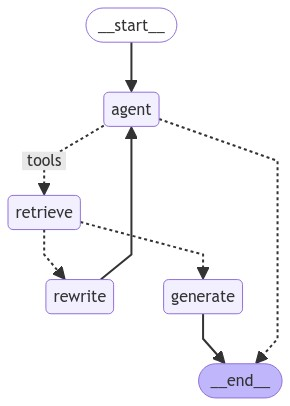

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [31]:
import pprint

inputs = {
    "messages": [
        ("user", "삼성전자주가"),
    ]
}

# inputs = {
#     "messages": [
#         ("user", "What does Lilian Weng say about the types of agent memory?"),
#     ]
# }

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---에이전트 호출---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QXFwbaWeByPJzKESLXiSrHBf', 'function': {'arguments': '{"query":"삼성전자주가"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_507c9469a1'}, id='run-bca15456-84c5-42b7-b77a-b16b8cbd99ea-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '삼성전자주가'}, 'id': 'call_QXFwbaWeByPJzKESLXiSrHBf', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='$$\n\n$$\n\n$$\n\n$$', name='retrieve_blog_posts', id='be0a0ae1-0d30-4f5f-a997-3c70b7eccb11', tool_call_id='call_QXFwbaWeByPJzKESLXiSrHBf')]}
'\n---\n'
---질문 변형---
"Output from node 'rewrite':"
'---'
{ 'messages': [ AIMessage(content='To enhance the clarity and spec